In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.utils import shuffle
import cv2
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB3
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

In [3]:
!pip install seaborn

In [4]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay


In [5]:
from sklearn import *

In [6]:
class main_class():
    def __init__(self,path_add):
        self.path_add=path_add

    def data_frame(self):
        images_link = list(self.path_add.glob(r'**/*.*'))
        images_name = [x.parents[0].stem for x in images_link]
        images_labels=preprocessing.LabelEncoder().fit_transform(images_name)

        df=pd.DataFrame(list(zip(images_link,images_name,images_labels)),columns=['Link','Name','label'])
        return df

    def img_show(self,image_links,plot_size,):
        df=image_links.sample(frac=1)
        fig = plt.figure(1, figsize=(30, 30))
        grid = ImageGrid(fig,121, nrows_ncols=(plot_size, 2), axes_pad=0.10)
        i = 0
        for category_id, category in enumerate(df.Name.unique()):
            for filepath in df[df['Name'] == category]['Link'].values[:2]:
                ax = grid[i]
                #img = image.load_img(filepath,(150,150))
                #img=image.img_to_array(img)
                #ax.imshow(img/255)


                image = Image.open(filepath).convert("L")
                arr = np.asarray(image)
                ax.imshow(arr, cmap='gray', vmin=0, vmax=255)
                ax.axis('off')

                if i % 2 == 2 - 1:
                    ax.text(600, 200, category, verticalalignment='center',fontsize=20,color = 'red')


                i+=1

        plt.show()

    def EfficientNet_call(self,df,EfficientNet,imsize,epoch,batch):
        image_data=[]
        for i in df.Link:
            img_pre=cv2.imread(str(i))
            img_pre=cv2.resize(img_pre, (imsize,imsize))
            image_data.append(img_pre)

        x=np.array(image_data)
        y=to_categorical(df.label)
        x_data, y_data=shuffle(x,y,random_state=42)
        xtrain,xtest,ytrain,ytest=model_selection.train_test_split(x_data, y_data, test_size=0.1, random_state=42)

        efficient = EfficientNet(weights='imagenet',include_top = False, input_shape=(imsize, imsize, 3))

        model = efficient.output
        model = tf.keras.layers.GlobalAveragePooling2D()(model)
        model = tf.keras.layers.Dropout(0.5)(model)
        model = tf.keras.layers.Dense(4, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation
             ='softmax')(model)
        model = tf.keras.models.Model(inputs = efficient.input , outputs = model)
        model.compile(loss = 'squared_hinge',
                      optimizer = "adam",
                      metrics=["accuracy"]
                      )
        model.summary()



        tensorboard = TensorBoard(log_dir="logs")
        checkpoint = ModelCheckpoint("efficient.h5",
                                     monitor='val_accuracy',
                                     mode = "auto",
                                     verbose = 1,
                                     save_best_only =True)
        reduce_LR = ReduceLROnPlateau(monitor="val_accuracy",
                                      factor = 0.3,
                                      patience = 2,
                                      min_delta=0.001,
                                      mode = "auto",
                                      verbose = 1)
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        history = model.fit(xtrain, ytrain,
                  validation_data =(xtest,ytest),
                  epochs = epoch,
                  verbose =1,
                  batch_size = batch,
                  callbacks = [tensorboard, checkpoint, reduce_LR,es])

        return model,xtrain,xtest,ytrain,ytest,history



In [11]:
# Create the Testing and Training directories
!mkdir -p /content/dataset/Testing/
!mkdir -p /content/dataset/Training/

# Copying to Testing directory
!cp -r /content/drive/MyDrive/dataset /content/dataset/Testing/

# Copying to Training directory
!cp -r /content/drive/MyDrive/dataset /content/dataset/Training/




In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
dataset_path = Path("/content/", "dataset")
data_info=main_class(dataset_path)
df=data_info.data_frame()

In [14]:
print(df)

                                                   Link                  Name  \
0     /content/dataset/Testing/dataset/diabetic_reti...  diabetic_retinopathy   
1     /content/dataset/Testing/dataset/diabetic_reti...  diabetic_retinopathy   
2     /content/dataset/Testing/dataset/diabetic_reti...  diabetic_retinopathy   
3     /content/dataset/Testing/dataset/diabetic_reti...  diabetic_retinopathy   
4     /content/dataset/Testing/dataset/diabetic_reti...  diabetic_retinopathy   
...                                                 ...                   ...   
8475  /content/dataset/Training/dataset/normal/2466_...                normal   
8476  /content/dataset/Training/dataset/normal/2849_...                normal   
8477  /content/dataset/Training/dataset/normal/2349_...                normal   
8478  /content/dataset/Training/dataset/normal/3013_...                normal   
8479  /content/dataset/Training/dataset/normal/2346_...                normal   

      label  
0         1  

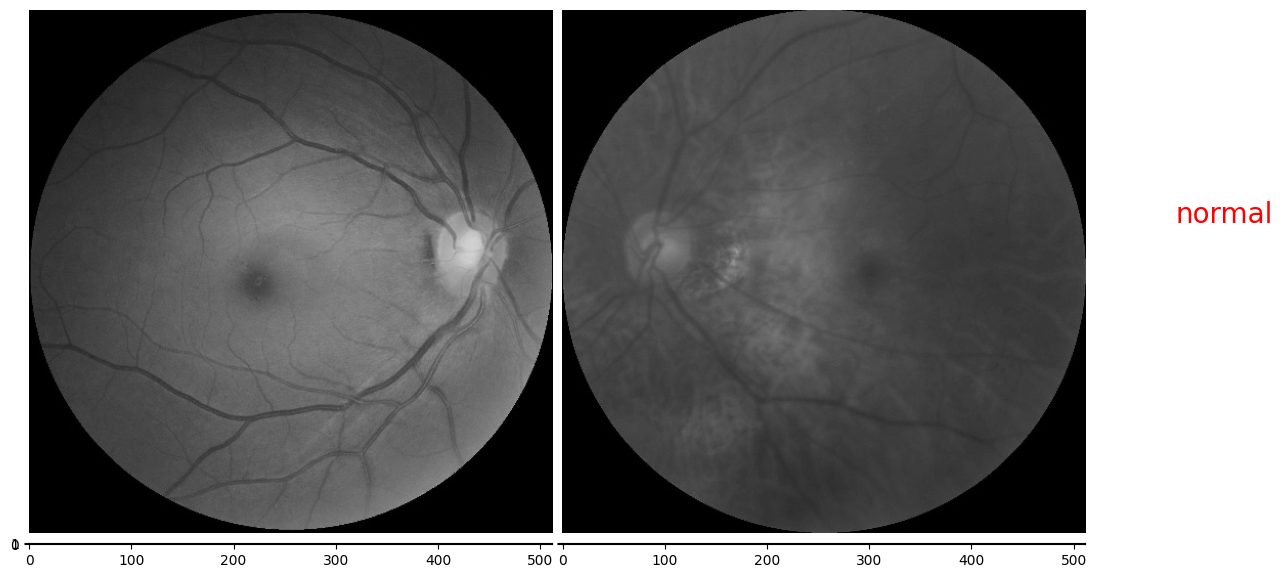

In [17]:
from PIL import Image
name_image=np.random.choice(np.unique(df.Name))
data_info.img_show(df[df.Name==name_image],2)

In [18]:
main_dt=data_info.EfficientNet_call(df,EfficientNetB3,224,20,32)

43941136/43941136 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


239/239 [==============================] - 197s 547ms/step - loss: 0.9363 - accuracy: 0.8430 - val_loss: 0.8519 - val_accuracy: 0.9068 - lr: 0.0010
Epoch 2/20
239/239 [==============================] - ETA: 0s - loss: 0.8585 - accuracy: 0.8985
Epoch 2: val_accuracy did not improve from 0.90684
239/239 [==============================] - 122s 510ms/step - loss: 0.8585 - accuracy: 0.8985 - val_loss: 0.9837 - val_accuracy: 0.7642 - lr: 0.0010
Epoch 3/20
239/239 [==============================] - ETA: 0s - loss: 0.8487 - accuracy: 0.9053
Epoch 3: val_accuracy improved from 0.90684 to 0.90802, saving model to efficient.h5
239/239 [==============================] - 123s 514ms/step - loss: 0.8487 - accuracy: 0.9053 - val_loss: 0.8470 - val_accuracy: 0.9080 - lr: 0.0010
Epoch 4/20
239/239 [==============================] - ETA: 0s - loss: 0.8223 - accuracy: 0.9333
Epoch 4: val_accuracy improved from 0.90802 to 0.92453, saving model to efficient.h5
239/239 [==============================] - 120s

predict test image plot

In [32]:
result_pre = np.argmax(main_dt[0].predict(main_dt[2]), axis=1)
result_acc = np.argmax(main_dt[4], axis=1)

plt.figure(figsize=(20, 20))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(main_dt[2][i])
    plt.title('cataract' if result_pre[i]==0
                else 'diabetic_retinopathy' if result_pre[i]==1
                else 'glaucoma' if result_pre[i]==2
                else 'normal',fontsize=20)
    plt.suptitle('Test Image plot and labels',fontsize=30)
    plt.axis("off")

plt.show()

Output hidden; open in https://colab.research.google.com to view.

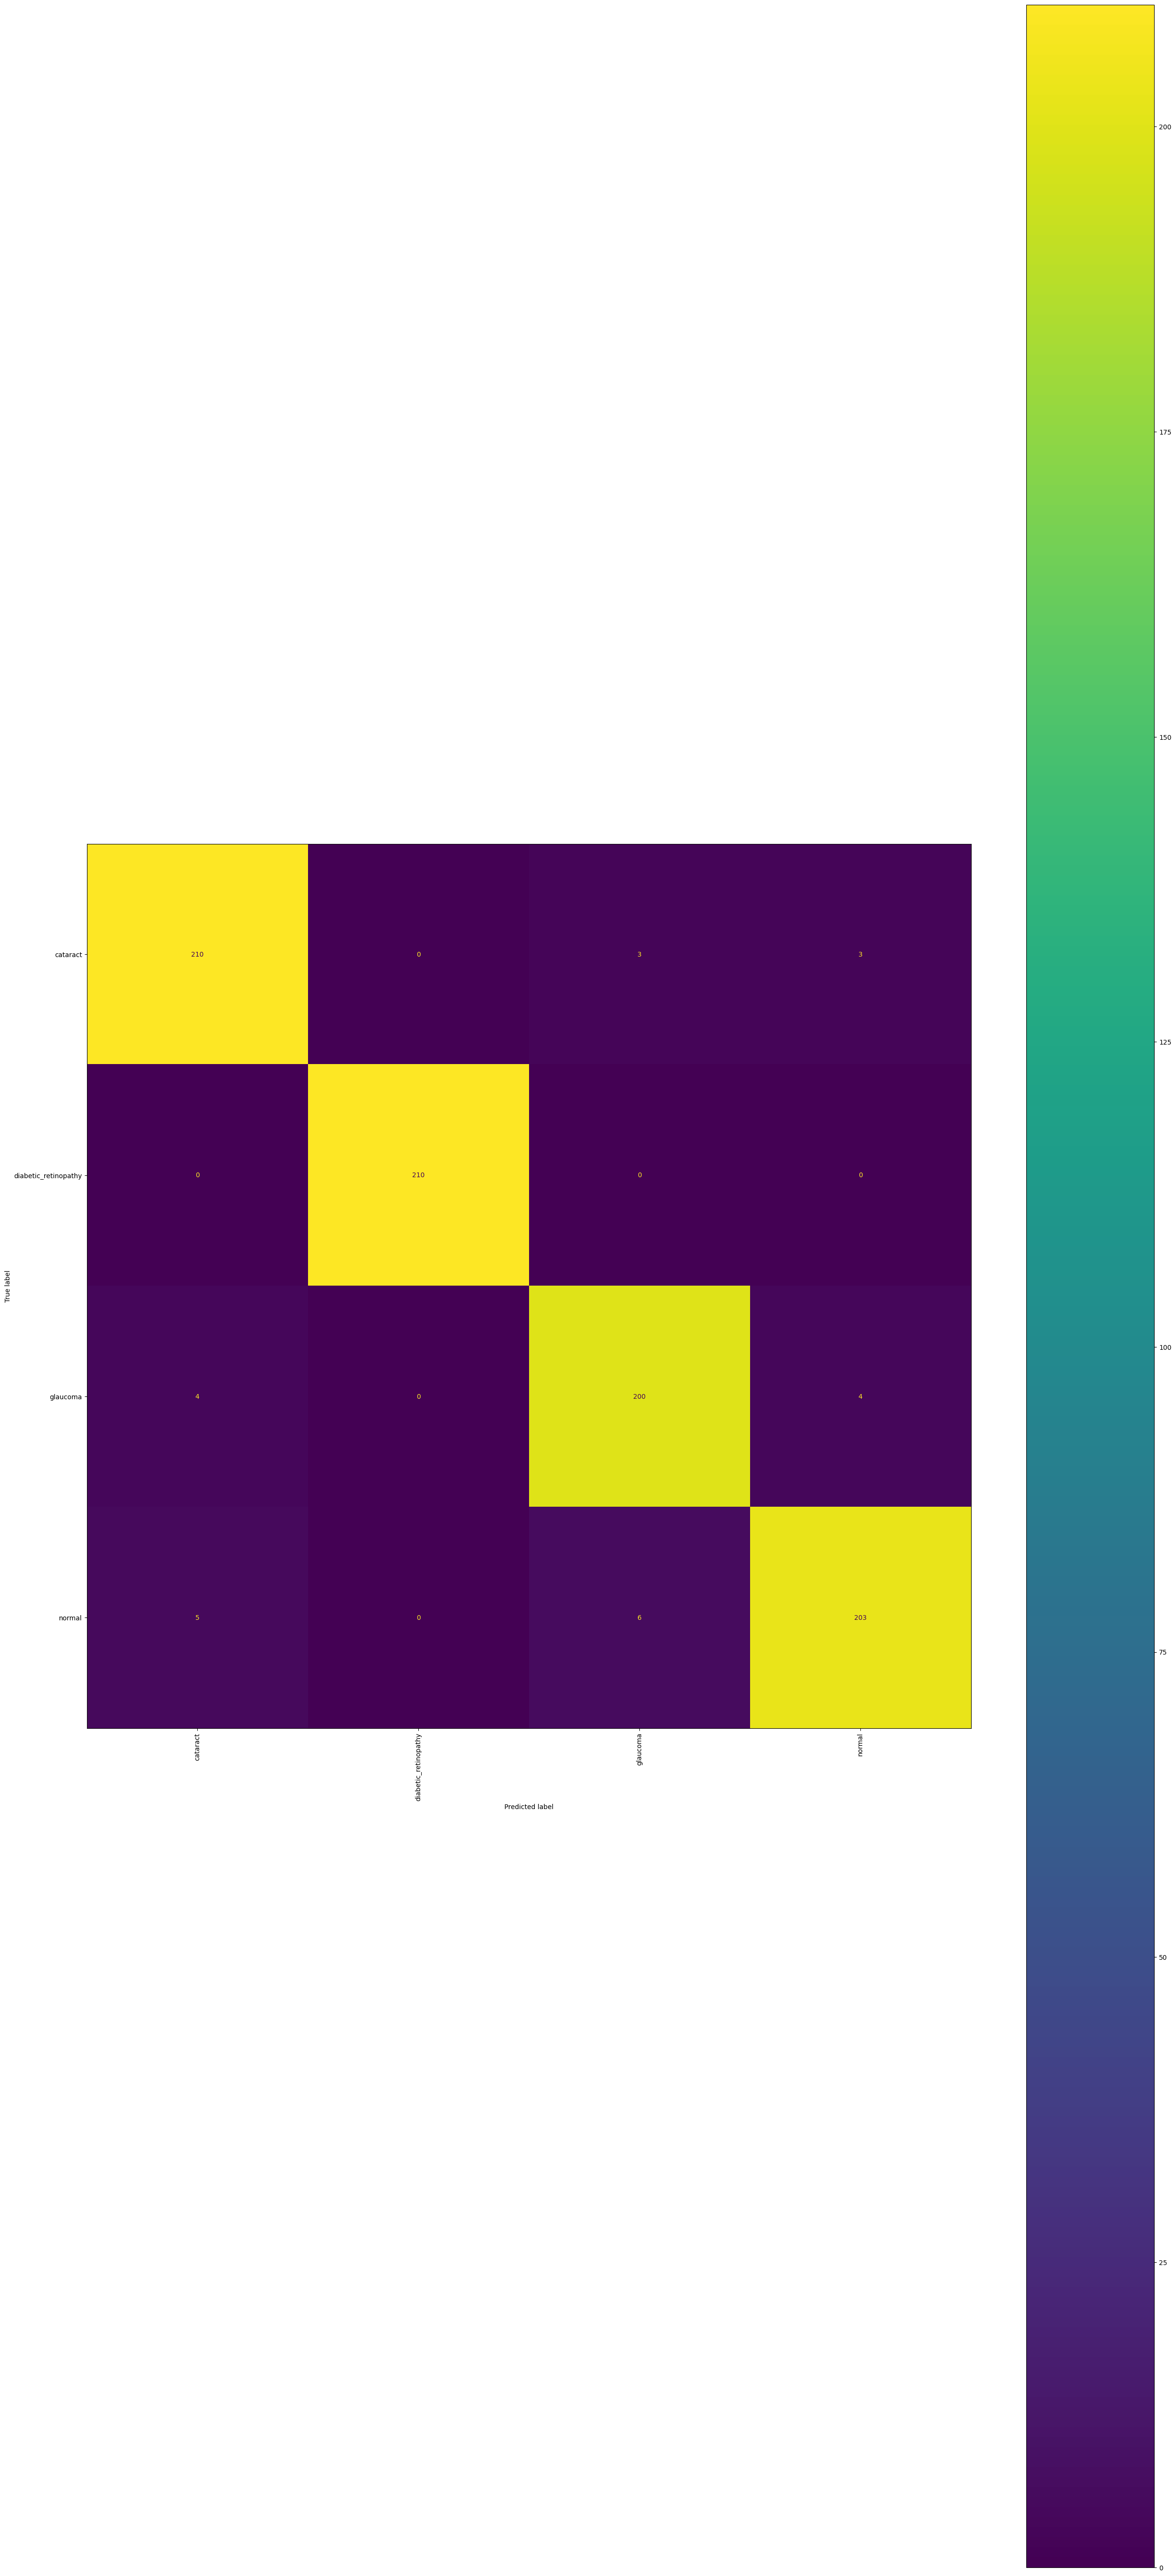

In [36]:
con_max = confusion_matrix(result_acc,result_pre)
cm = confusion_matrix(result_acc,result_pre)
cmp = ConfusionMatrixDisplay(cm,display_labels = ['cataract', 'diabetic_retinopathy','glaucoma', 'normal'])
fig, ax = plt.subplots(figsize=(30,70))
cmp.plot(ax=ax, xticks_rotation=90)

In [37]:
print(classification_report(result_acc,result_pre,target_names=['cataract', 'diabetic_retinopathy','glaucoma', 'normal']))

                      precision    recall  f1-score   support

            cataract       0.96      0.97      0.97       216
diabetic_retinopathy       1.00      1.00      1.00       210
            glaucoma       0.96      0.96      0.96       208
              normal       0.97      0.95      0.96       214

            accuracy                           0.97       848
           macro avg       0.97      0.97      0.97       848
        weighted avg       0.97      0.97      0.97       848



In [40]:
df_acc=pd.DataFrame()
df_acc['Accuracy']=main_dt[5].history['accuracy']
df_acc['Value Accuracy']=main_dt[5].history['val_accuracy']
df_acc

,Accuracy,Value Accuracy
0,0.843029,0.906840
1,0.898454,0.764151
2,0.905267,0.908019
3,0.933307,0.924528
4,0.930031,0.936321
5,0.928066,0.930425
6,0.923873,0.898585
7,0.946279,0.950472
8,0.958071,0.948113
9,0.965278,0.942217


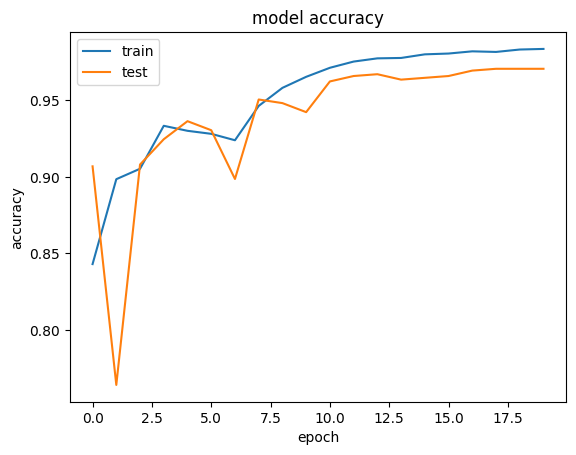

In [39]:
plt.plot(main_dt[5].history['accuracy'])
plt.plot(main_dt[5].history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()